In [1]:
import numpy as np
import os

In [54]:
class ChunkifiedDataset:
    def __init__(self):
        self.arrays_in_chunk = 500
        self.chunk_loaded_start = -1
        self.chunk_loaded_end = -1
        self.data_root = 'uk_data_np'
        self.chunk_root = os.path.join(self.data_root, 'data')
        self._load_filename_data()
        self.chunk_np = None

    def _load_filename_data(self):
        all_chunk_names = os.listdir(self.chunk_root)
        self.chunk_nos = set() # stores end of chunk indices that stores names
        self.highest_chunk_no = 0
        self.highest_chunk_name = ''
        for chunk_name in all_chunk_names:
            chunk_name = chunk_name.replace('.npz', '')
            try:
                chunk_no = int(chunk_name)
            except:
                continue
            self.chunk_nos.add(chunk_no)

            if self.highest_chunk_no < chunk_no:
                self.highest_chunk_no = chunk_no
                self.highest_chunk_name = chunk_name
    
    def _get_chunk_bounds(self, idx):
        chunk_start = int(idx / self.arrays_in_chunk) * self.arrays_in_chunk
        chunk_end = chunk_start + self.arrays_in_chunk - 1
        return (chunk_start, chunk_end)
    
    def __len__(self):
        return self.highest_chunk_no + 1

    def _ensure_chunk_loaded(self, bounds):
        end_idx = bounds[1]
        start_idx = bounds[0]
        if self.chunk_loaded_start == start_idx and self.chunk_loaded_end == end_idx:
            return
        
        self.chunk_np = np.load(os.path.join(self.chunk_root, f'{end_idx}.npz'))['data']
        self.chunk_loaded_start = start_idx
        self.chunk_loaded_end = end_idx

    def _accessslice_within_chunk(self, key: slice, bounds):
        start_bound = bounds[0]
        self._ensure_chunk_loaded(bounds)
        return self.chunk_np[key.start - start_bound: key.stop - start_bound: key.step]

    def __getitem__(self, key):
        if isinstance(key, int):
            bounds = self._get_chunk_bounds(key)
            start_idx, _ = bounds
            self._ensure_chunk_loaded(bounds)
            return self.chunk_np[key - start_idx]

        if isinstance(key, slice):
            start_bounds = self._get_chunk_bounds(key.start)
            end_bounds = self._get_chunk_bounds(key.stop)
            if start_bounds == end_bounds:
                return self._accessslice_within_chunk(key, start_bounds)
            
            if start_bounds[1] + 1 != end_bounds[0]:
                raise KeyError('Bro, your damn slice is massive yo', key)
            
            slice_0 = slice(key.start, start_bounds[1], key.step)
            section_0 = self._accessslice_within_chunk(slice_0, start_bounds)
            slice_1 = slice(end_bounds[0], key.stop, key.step)
            section_1 = self._accessslice_within_chunk(slice_1, end_bounds)
            section = np.concatenate([section_0, section_1], axis=0)
            return section

        raise KeyError('Bro like idek what to do here ok?', key)

In [55]:
datasetpls = ChunkifiedDataset()

In [56]:
import matplotlib.pyplot as plt

In [57]:
datasetpls[29998 : 30005].shape

(6, 891, 1843)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

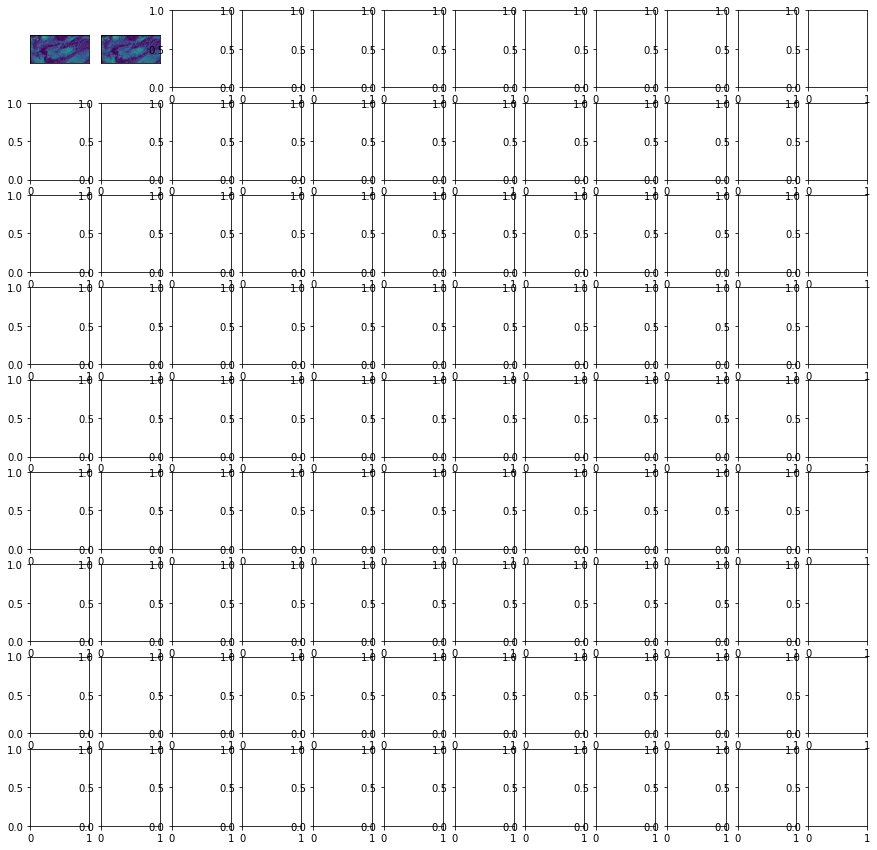

In [63]:
portion = datasetpls[19950:20059]
idx = 0
fig, axss = plt.subplots(9, 12, figsize=(15,15))
prev = None
for axs in axss:
    for ax in axs:
        piece = portion[idx]
        ax.imshow(piece, cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        idx += 1
        if :
            if (prev == piece).all():
                print("WE HAVE A PROBLEM, SHITS EQUAL????")
        prev = piece
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)